# Author: Swayam Mayankkumar Patel


# Task 1: User-based Collaborative Filtering


In [2]:
# Start from here to write your code for Task 1. Please feel free to add more cells in this ipynb file. 
# Don't forget about comments.


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Load the dataset
path_movies = "C:\\Users\\swaya\\Downloads\\A3_s3994439\\ml-1m\\ml-1m\\movies.dat"
path_ratings = "C:\\Users\\swaya\\Downloads\\A3_s3994439\\ml-1m\\ml-1m\\ratings.dat"
path_users = "C:\\Users\\swaya\\Downloads\\A3_s3994439\\ml-1m\\ml-1m\\users.dat"

## Load the datasets using a different encoding
df_movies = pd.read_csv(path_movies, sep='::', names=['movie_id', 'title', 'genres'], engine='python', encoding='ISO-8859-1')
df_ratings = pd.read_csv(path_ratings, sep='::', names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')
df_users = pd.read_csv(path_users, sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], engine='python')

df_movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [4]:
# Split the genres string on '|' and flatten the list of lists
all_genres = [genre for sublist in df_movies['genres'].str.split('|').tolist() for genre in sublist]

# Convert to a set to get unique genres
unique_genres = set(all_genres)

print(unique_genres)


{'Musical', 'Animation', 'Comedy', 'Thriller', 'War', 'Documentary', 'Film-Noir', 'Romance', 'Mystery', 'Drama', 'Sci-Fi', 'Fantasy', 'Horror', 'Action', "Children's", 'Western', 'Adventure', 'Crime'}


In [5]:
df_ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [6]:
df_users

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [7]:
# Convert the ratings into a user-item matrix
user_item_matrix = df_ratings.pivot(index='user_id', columns='movie_id', values='rating')

# Choose a random user
active_user = user_item_matrix.sample(1).index[0]

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)



In [8]:
def predict_ratings(k):
    # Get 'k' most similar users to the active user (excluding the active user itself)
    similar_users = user_similarity_df[active_user].sort_values(ascending=False).iloc[1:k+1].index
    
    # Predict ratings based on user similarity
    predicted_ratings = user_item_matrix.loc[similar_users].mean()
    
    return predicted_ratings



In [9]:
def knn_cf_recommendations(user_id, user_item_matrix, n_neighbors=20, top_n=30):
    """
    Recommend movies using KNN-based Collaborative Filtering.
    
    Parameters:
    - user_id: ID of the user for whom recommendations are to be made
    - user_item_matrix: User-Item interaction matrix
    - n_neighbors: Number of neighbors to consider for KNN
    - top_n: Number of top recommendations to return
    
    Returns:
    - List of top_n movie recommendations
    """
    
    # Replace NaN with 0 for KNN
    user_item_matrix_filled = user_item_matrix.fillna(0)
    
    # Fit the KNN model
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
    knn.fit(user_item_matrix_filled)
    
    # Get the distances and indices of the nearest neighbors for the given user
    distances, indices = knn.kneighbors(user_item_matrix_filled.loc[user_id].values.reshape(1, -1))
    
    # Get the list of movies rated by the user
    known_movies = set(user_item_matrix.loc[user_id].dropna().index)
    
    # Calculate the weighted average rating for each movie based on neighbors
    movie_scores = {}
    for idx, distance in zip(indices[0], distances[0]):
        neighbor_ratings = user_item_matrix.iloc[idx].dropna()
        for movie, rating in neighbor_ratings.items():
            if movie not in known_movies:
                if movie not in movie_scores:
                    movie_scores[movie] = [0, 0]
                movie_scores[movie][0] += rating * (1 - distance)  # Weighted sum of ratings
                movie_scores[movie][1] += (1 - distance)  # Sum of weights
                
    # Calculate the weighted average
    for movie in movie_scores:
        movie_scores[movie] = movie_scores[movie][0] / movie_scores[movie][1]
    
    # Get the top_n movie recommendations
    recommended_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:top_n]
    
    return recommended_movies


In [10]:
def compute_rmse(predictions, real_ratings):
    # Filter out NaN values from both the predictions and real ratings
    valid_indices = predictions.dropna().index.intersection(real_ratings.dropna().index)
    predictions_filtered = predictions[valid_indices]
    real_ratings_filtered = real_ratings[valid_indices]
    
    # Calculate RMSE between the filtered predicted and actual ratings
    return np.sqrt(mean_squared_error(predictions_filtered, real_ratings_filtered))



In [11]:
# Study the impact of the parameter K (of KNN)
k_values = [5, 10, 15, 20, 25]
rmse_values = []

print("Evaluating RMSE for various values of k:")

for k in k_values:
    predictions = predict_ratings(k)
    rmse = compute_rmse(predictions, user_item_matrix.loc[active_user])
    rmse_values.append(rmse)
    print(f"For k = {k}, RMSE = {rmse:.4f}")

print("\nSummary:")
for k, rmse in zip(k_values, rmse_values):
    print(f"k={k}: {rmse:.4f}")


Evaluating RMSE for various values of k:
For k = 5, RMSE = 0.8372
For k = 10, RMSE = 0.7870
For k = 15, RMSE = 0.7610
For k = 20, RMSE = 0.7473
For k = 25, RMSE = 0.7331

Summary:
k=5: 0.8372
k=10: 0.7870
k=15: 0.7610
k=20: 0.7473
k=25: 0.7331


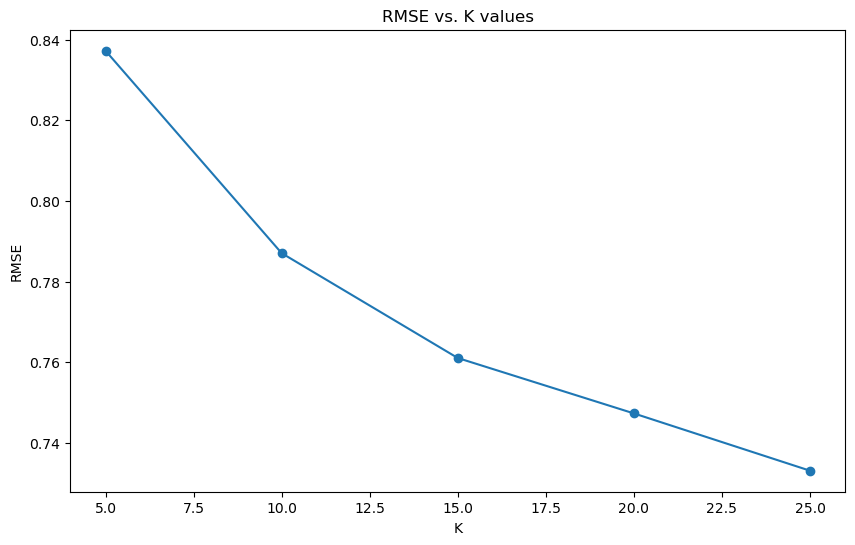

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o')
plt.title("RMSE vs. K values")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.grid(False)
plt.show()


# Task 2: Item-based Filtering

In [13]:
np.random.seed(42)  # for reproducibility
active_movie = np.random.choice(user_item_matrix.columns)
print(f"Active Movie: {active_movie}")


Active Movie: 3405


In [14]:
item_user_matrix = user_item_matrix.T


In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

def cosine_similarity_modified(x, y):
    """
    Compute cosine similarity between two 1D arrays.
    """
    x = x.values.reshape(1, -1)
    y = y.values.reshape(1, -1)
    return cosine_similarity(x, y)[0][0]



In [16]:
def euclidean_distance_modified(x, y):
    """
    Compute negative euclidean distance between two 1D arrays.
    """
    return -euclidean(x, y)




In [17]:
def knn_predict_item_based(user, movie, k=10, metric='cosine'):
    """
    Predict rating using item-based collaborative filtering with KNN.
    """
    # Get all movies except the active movie
    other_movies = [m for m in item_user_matrix.index if m != movie]
    
    # Compute similarity of all other movies to the active movie
    similarities = {}
    for other_movie in other_movies:
        if metric == 'cosine':
            sim = cosine_similarity_modified(item_user_matrix.loc[movie].fillna(0), item_user_matrix.loc[other_movie].fillna(0))
        elif metric == 'euclidean':
            sim = euclidean_distance_modified(item_user_matrix.loc[movie].fillna(0), item_user_matrix.loc[other_movie].fillna(0))
        similarities[other_movie] = sim
    
    # Sort movies by similarity
    sorted_movies = sorted(similarities, key=similarities.get, reverse=True)
    
    # Get top-k similar movies
    top_k_movies = sorted_movies[:k]
    
    # Compute the predicted rating
    sum_similarities = sum([similarities[movie] for movie in top_k_movies])
    predicted_rating = sum([similarities[movie] * user_item_matrix.loc[user, movie] for movie in top_k_movies]) / sum_similarities
    
    return predicted_rating

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import mean_squared_error
from math import sqrt



In [19]:
#  df_ratings is dataframe and it has columns: 'user_id', 'movie_id', 'rating'
user_item_matrix = df_ratings.pivot(index='user_id', columns='movie_id', values='rating')
item_matrix_filled = user_item_matrix.fillna(0).T



In [20]:
def compute_similarities(method='cosine'):
    if method == 'cosine':
        similarities = cosine_similarity(item_matrix_filled)
    elif method == 'euclidean':
        similarities = 1 / (1 + euclidean_distances(item_matrix_filled))
    return similarities



In [21]:
def predict_ratings(movie_id, user_id, k, similarity_matrix):
    similar_movies = np.argsort(-similarity_matrix[movie_id])[:k+1]
    similar_movies = similar_movies[similar_movies != movie_id]  # Remove the movie itself
    ratings = user_item_matrix.loc[user_id].dropna()
    rated_similar_movies = [m for m in similar_movies if m in ratings.index]
    
    numerator = sum([similarity_matrix[movie_id, m] * ratings[m] for m in rated_similar_movies])
    denominator = sum([abs(similarity_matrix[movie_id, m]) for m in rated_similar_movies])
    
    # If the denominator is zero (i.e., no similar movies rated by the user), return the user's mean rating or another default value
    predicted_rating = numerator / denominator if denominator != 0 else ratings.mean()
    
    return predicted_rating




In [22]:
# Randomly select 5 movies and users who rated those movies
np.random.seed(42)
selected_movie_ids = np.random.choice(user_item_matrix.columns, 5, replace=False)

# Calculate RMSE for cosine similarity
cosine_similarities = compute_similarities('cosine')
euclidean_similarities = compute_similarities('euclidean')
k_values = [5, 10, 15, 20, 25]

for movie_id in selected_movie_ids:
    user_ids = user_item_matrix.index[~user_item_matrix[movie_id].isna()]

    # Fetch movie name using movie_id from df_movies
    movie_name = df_movies[df_movies['movie_id'] == movie_id]['title'].values[0]

    print(f"Results for Movie: {movie_name}\n{'-'*50}")

    for k in k_values:
        predictions_cosine = [predict_ratings(movie_id, user_id, k, cosine_similarities) for user_id in user_ids]
        predictions_euclidean = [predict_ratings(movie_id, user_id, k, euclidean_similarities) for user_id in user_ids]

        actual_ratings = user_item_matrix.loc[user_ids, movie_id].dropna().values

        rmse_cosine = sqrt(mean_squared_error(actual_ratings, predictions_cosine))
        rmse_euclidean = sqrt(mean_squared_error(actual_ratings, predictions_euclidean))

        print(f"RMSE for k={k} with Cosine Similarity: {rmse_cosine:.2f}")
        print(f"RMSE for k={k} with Euclidean Similarity: {rmse_euclidean:.2f}")
        print("-" * 50)

    print("\n")


Results for Movie: Bride of the Monster (1956)
--------------------------------------------------
RMSE for k=5 with Cosine Similarity: 1.44
RMSE for k=5 with Euclidean Similarity: 1.43
--------------------------------------------------
RMSE for k=10 with Cosine Similarity: 1.49
RMSE for k=10 with Euclidean Similarity: 1.53
--------------------------------------------------
RMSE for k=15 with Cosine Similarity: 1.43
RMSE for k=15 with Euclidean Similarity: 1.52
--------------------------------------------------
RMSE for k=20 with Cosine Similarity: 1.54
RMSE for k=20 with Euclidean Similarity: 1.55
--------------------------------------------------
RMSE for k=25 with Cosine Similarity: 1.48
RMSE for k=25 with Euclidean Similarity: 1.57
--------------------------------------------------


Results for Movie: Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982)
--------------------------------------------------
RMSE for k=5 with Cosine Similarity: 0.81
RMSE for k=5 with Euclid

In [23]:
import matplotlib.pyplot as plt

cosine_rmse_values = []
euclidean_rmse_values = []

k_values = [5, 10, 15, 20, 25]
for k in k_values:
    predictions_cosine = [predict_ratings(movie_id, user_id, k, cosine_similarities) for user_id in user_ids]
    predictions_euclidean = [predict_ratings(movie_id, user_id, k, euclidean_similarities) for user_id in user_ids]
    
    actual_ratings = user_item_matrix.loc[user_ids, movie_id].dropna().values
    
    rmse_cosine = sqrt(mean_squared_error(actual_ratings, predictions_cosine))
    rmse_euclidean = sqrt(mean_squared_error(actual_ratings, predictions_euclidean))
    
    cosine_rmse_values.append(rmse_cosine)
    euclidean_rmse_values.append(rmse_euclidean)



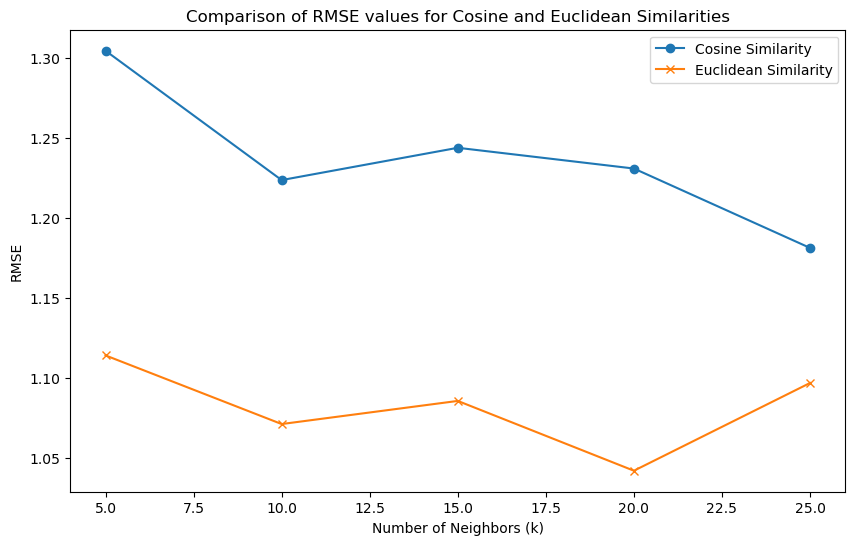

In [24]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(k_values, cosine_rmse_values, marker='o', label='Cosine Similarity')
plt.plot(k_values, euclidean_rmse_values, marker='x', label='Euclidean Similarity')
plt.title('Comparison of RMSE values for Cosine and Euclidean Similarities')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(False)
plt.show()


# Task 3: A Better Recommender System

### Task 3.1

In [25]:
from scipy.sparse.linalg import svds

# Matrix Factorization using SVD

def Option1RecSys(matrix, k=50):
    """
    Build the SVD recommender model.
    
    Parameters:
    - matrix: the user-item matrix
    - k: number of singular values to consider
    
    Returns:
    - predicted matrix
    """
    # Normalize by subtracting mean
    matrix = matrix - np.nanmean(matrix, axis=0)
    matrix = np.nan_to_num(matrix)
    
    # Singular Value Decomposition
    U, sigma, Vt = svds(matrix, k=k)
    
    # Convert sigma to diagonal matrix
    sigma = np.diag(sigma)
    
    # Predicted ratings
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    
    # Add the mean back to get the actual predicted ratings
    predicted_ratings += np.mean(matrix, axis=0)
    
    return predicted_ratings




In [26]:
# Get the predicted ratings matrix
k = 50  # This can be tuned for optimal performance
predicted_matrix = Option1RecSys(user_item_matrix.values, k)

# Convert to DataFrame for easier handling
predicted_ratings = pd.DataFrame(predicted_matrix, columns=user_item_matrix.columns, index=user_item_matrix.index)

predicted_ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.315526,0.026481,0.007548,0.009738,0.000420,-0.004758,0.011330,0.016884,-0.019861,-0.035751,...,-0.013356,-0.000674,-0.000325,0.006103,0.005357,0.007347,0.014704,0.003085,0.006956,0.015183
2,0.088268,0.015578,0.102554,0.034177,0.041039,-0.071238,-0.010403,-0.015488,-0.014868,0.010570,...,0.004159,0.001256,-0.002200,0.010572,-0.007689,0.046983,-0.012731,0.004146,0.001267,0.029249
3,-0.044258,0.008364,-0.004408,0.013243,0.022715,-0.004312,0.061859,0.009004,0.006398,0.046029,...,0.001158,0.000928,0.000383,-0.002149,0.006411,-0.065303,-0.018111,0.000040,0.008400,-0.013745
4,-0.011928,0.046176,0.038459,0.010965,0.037326,-0.003163,0.003824,0.008164,-0.002293,0.016211,...,-0.009244,-0.001983,0.005774,0.016364,0.006078,0.037211,-0.006179,0.003713,-0.000523,0.010678
5,-0.199466,-0.023844,-0.007090,-0.010204,0.042493,-0.157014,0.119222,0.023255,0.009167,-0.070733,...,0.052422,-0.008378,0.023563,-0.008764,-0.029981,-0.176223,-0.083356,-0.017792,-0.017351,-0.180873


In [27]:
def compute_rmse_svd(predicted, original):
    """
    Compute RMSE between the predicted ratings matrix and the original ratings matrix.
    
    Parameters:
    - predicted: predicted ratings matrix
    - original: original ratings matrix
    
    Returns:
    - RMSE
    """
    # Get indices of non-NaN values
    ix = ~np.isnan(original)
    
    # Calculate RMSE only for the original non-NaN values
    mse = np.mean((original[ix] - predicted[ix])**2)
    
    return np.sqrt(mse)

# Compute RMSE for the SVD recommender
rmse_svd = compute_rmse_svd(predicted_ratings.values, user_item_matrix.values)
rmse_svd


3.703232641905401

In [28]:
def compute_rmse_svd(predicted, original):
    """
    Compute RMSE between the predicted ratings matrix and the original ratings matrix.
    
    Parameters:
    - predicted: predicted ratings matrix
    - original: original ratings matrix
    
    Returns:
    - RMSE
    """
    # Get indices of non-NaN values
    ix = ~np.isnan(original)
    
    # Calculate RMSE only for the original non-NaN values
    mse = np.mean((original[ix] - predicted[ix])**2)
    
    return np.sqrt(mse)




In [29]:
# Function to get random subset of data
def get_random_subset(matrix, fraction=0.5):
    """
    Returns a subset of the matrix by randomly setting a fraction of its elements to NaN.
    
    Parameters:
    - matrix: input matrix
    - fraction: fraction of elements to retain
    
    Returns:
    - matrix with (1 - fraction) elements set to NaN
    """
    subset = matrix.copy()
    ix = np.random.choice([True, False], size=matrix.shape, p=[fraction, 1-fraction])
    subset[~ix] = np.nan
    return subset



In [30]:
# Compute RMSE for the SVD recommender for 5 random subsets
for i in range(5):
    random_subset = get_random_subset(user_item_matrix.values, fraction=0.5)
    rmse_svd = compute_rmse_svd(predicted_ratings.values, random_subset)
    print(f"RMSE for random subset {i+1}: {rmse_svd:.4f}")

RMSE for random subset 1: 3.7028
RMSE for random subset 2: 3.7024
RMSE for random subset 3: 3.7034
RMSE for random subset 4: 3.7027
RMSE for random subset 5: 3.7051


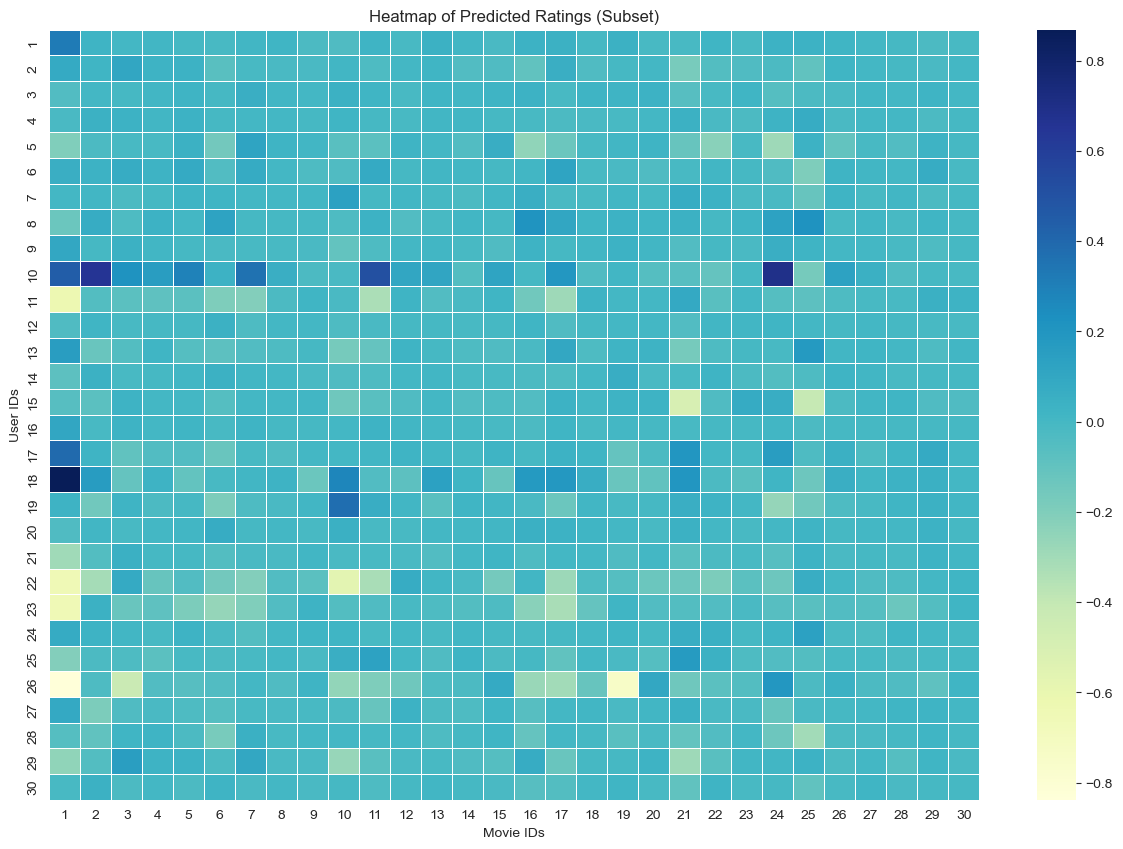

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the plotting environment
sns.set_style('whitegrid')

# Plotting Heatmap for a subset of predicted ratings
plt.figure(figsize=(15, 10))
subset_predicted_ratings = predicted_ratings.iloc[:30, :30]  # Taking a subset for visualization purposes
sns.heatmap(subset_predicted_ratings, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Predicted Ratings (Subset)')
plt.xlabel('Movie IDs')
plt.ylabel('User IDs')
plt.show()




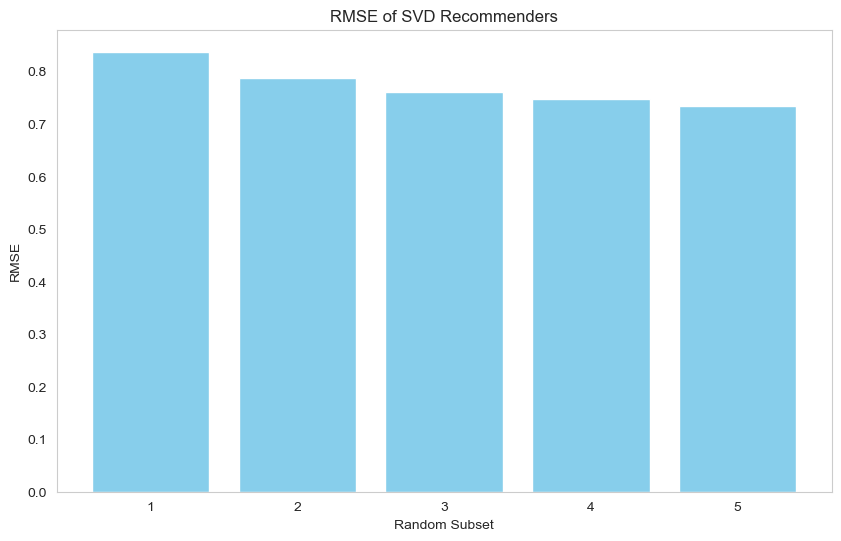

In [32]:
# Plotting the RMSE values
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), rmse_values, color='skyblue')
plt.xlabel('Random Subset')
plt.ylabel('RMSE')
plt.title('RMSE of SVD Recommenders')
plt.xticks(range(1, 6))
plt.grid(False)

plt.show()

#### Task 3.2

In [33]:
# Identify users who have rated more than 100 movies
users_100_ratings = df_ratings['user_id'].value_counts()
users_100_ratings = users_100_ratings[users_100_ratings > 100].index.tolist()

# Randomly select 5 users from the above list
selected_users = np.random.choice(users_100_ratings, 5, replace=False)
selected_users


array([5648, 3074, 1333, 3796, 4287])

In [34]:
# Selecting users who have rated more than 100 movies
user_counts = df_ratings['user_id'].value_counts()
selected_users = user_counts[user_counts > 100].index[:5]

selected_users


Int64Index([4169, 1680, 4277, 1941, 1181], dtype='int64')

In [35]:
# Get users who have rated more than 100 movies
user_counts = df_ratings['user_id'].value_counts()
users_over_100 = user_counts[user_counts > 100].index

# Randomly select 5 of these users
selected_users = np.random.choice(users_over_100, 5, replace=False)
selected_users

array([4415, 5317, 3128, 1073, 2097], dtype=int64)

In [36]:
# Calculate average rating for each movie
movie_avg_ratings = df_ratings.groupby('movie_id')['rating'].mean()

# Sort movies by average rating in descending order
top_movies = movie_avg_ratings.sort_values(ascending=False).index[:30]

# Recommendations for each user will be the same using the MovieAvg method
movieavg_recommendations = {user: top_movies.tolist() for user in selected_users}


In [37]:
# 1. SVD-based Recommender System:

def Option1RecSys(matrix, k=50):
    matrix = matrix - np.nanmean(matrix, axis=0)
    matrix = np.nan_to_num(matrix)
    U, sigma, Vt = svds(matrix, k=k)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    predicted_ratings += np.mean(matrix, axis=0)
    return predicted_ratings

# Using the user-item matrix from the previous task
predicted_matrix = Option1RecSys(user_item_matrix.values, k=50)
predicted_ratings = pd.DataFrame(predicted_matrix, columns=user_item_matrix.columns, index=user_item_matrix.index)

In [38]:
def Option1RecSys(matrix, k=50):
    # Ensure the matrix is two-dimensional
    if len(matrix.shape) != 2:
        raise ValueError("The input matrix is not two-dimensional!")
    
    # Check if the matrix is entirely NaN values
    if np.all(np.isnan(matrix)):
        raise ValueError("The input matrix contains only NaN values!")
    
    # Subtract the mean
    mean_values = np.nanmean(matrix, axis=0)
    matrix = matrix - mean_values
    matrix = np.nan_to_num(matrix)
    
    # Compute SVD
    U, sigma, Vt = svds(matrix, k=k)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    predicted_ratings += mean_values
    return predicted_ratings

# Using the user-item matrix from the previous task
predicted_matrix = Option1RecSys(user_item_matrix.values, k=50)
predicted_ratings = pd.DataFrame(predicted_matrix, columns=user_item_matrix.columns, index=user_item_matrix.index)


In [39]:
# 2. Select Users for Recommendations:

# Users who have rated more than 100 movies
user_counts = df_ratings['user_id'].value_counts()
users_over_100 = user_counts[user_counts > 100].index

# Randomly select 5 of these users
selected_users = np.random.choice(users_over_100, 5, replace=False)



In [40]:
# 3. Generate Recommendations:

# a. Using Average Movie Ratings:
movie_avg_ratings = df_ratings.groupby('movie_id')['rating'].mean()
top_movies = movie_avg_ratings.sort_values(ascending=False).index[:30]
movieavg_recommendations = {user: top_movies.tolist() for user in selected_users}

# b. Using k-Nearest Neighbors Collaborative Filtering:

from sklearn.neighbors import NearestNeighbors

# Fill NaN values in the user-item matrix with 0
user_item_matrix_filled = user_item_matrix.fillna(0)

# Train KNN model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
model_knn.fit(user_item_matrix_filled)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [41]:
def get_knncf_recommendations(user, user_item_matrix, model, k=1):  # default k set to 1
    distances, indices = model.kneighbors(user_item_matrix.loc[user].values.reshape(1, -1), n_neighbors=k+1)
    # Translate the k-nearest neighbor indices to actual user IDs
    neighbor_ids = [user_item_matrix.index[i] for i in indices[0]]
    # Removing the user itself from the recommendations
    neighbor_ids = [id for id in neighbor_ids if id != user]
    return neighbor_ids

knncf_recommendations = {user: get_knncf_recommendations(user, user_item_matrix_filled, model_knn) for user in selected_users}

# Display KNN-CF Recommendations
print("Recommendations using k-Nearest Neighbors Collaborative Filtering:")
print("-----------------------------------------------------------------")
for user, neighbors in knncf_recommendations.items():
    print(f"\nUser ID: {user} has similar preferences to User IDs: {', '.join(map(str, neighbors))}")

print("\nDone!")


Recommendations using k-Nearest Neighbors Collaborative Filtering:
-----------------------------------------------------------------

User ID: 4291 has similar preferences to User IDs: 1985

User ID: 5755 has similar preferences to User IDs: 1285

User ID: 307 has similar preferences to User IDs: 2544

User ID: 3992 has similar preferences to User IDs: 2012

User ID: 3108 has similar preferences to User IDs: 3823

Done!


In [42]:
# 1. SVD-based Recommender System:
predicted_matrix = Option1RecSys(user_item_matrix.values, k=50)
predicted_ratings = pd.DataFrame(predicted_matrix, columns=user_item_matrix.columns, index=user_item_matrix.index)



In [43]:
# 2. Select Users for Recommendations:
user_counts = df_ratings['user_id'].value_counts()
users_over_100 = user_counts[user_counts > 100].index
selected_users = np.random.choice(users_over_100, 5, replace=False)

# Display selected users
print("Selected Users:")
print("----------------")
for user in selected_users:
    print(f"User ID: {user}")

print("\n")



Selected Users:
----------------
User ID: 5349
User ID: 3929
User ID: 4748
User ID: 2857
User ID: 5501




In [44]:
# 3. Generate Recommendations:

# a. Using Average Movie Ratings:
movie_avg_ratings = df_ratings.groupby('movie_id')['rating'].mean()
top_movies = movie_avg_ratings.sort_values(ascending=False).index[:30]
movieavg_recommendations = {user: top_movies.tolist() for user in selected_users}

# Display Average Movie Recommendations
print("Recommendations using Average Movie Ratings:")
print("--------------------------------------------")
for user, movies in movieavg_recommendations.items():
    user_info = df_users[df_users['user_id'] == user].iloc[0]
    print(f"\nUser ID: {user}, Gender: {user_info['gender']}, Age: {user_info['age']}, Occupation: {user_info['occupation']}, Zip-code: {user_info['zip_code']}")
    recommended_movie_titles = df_movies[df_movies['movie_id'].isin(movies)]['title'].tolist()
    for idx, movie in enumerate(recommended_movie_titles, 1):
        print(f"{idx}. {movie}")

print("\n")

# b. Using k-Nearest Neighbors Collaborative Filtering:
knncf_recommendations = {user: get_knncf_recommendations(user, user_item_matrix_filled, model_knn) for user in selected_users}

# Display KNN-CF Recommendations
print("Recommendations using k-Nearest Neighbors Collaborative Filtering:")
print("-----------------------------------------------------------------")
for user, movies in knncf_recommendations.items():
    user_info = df_users[df_users['user_id'] == user].iloc[0]
    print(f"\nUser ID: {user}, Gender: {user_info['gender']}, Age: {user_info['age']}, Occupation: {user_info['occupation']}, Zip-code: {user_info['zip_code']}")
    recommended_movie_titles = df_movies[df_movies['movie_id'].isin(movies)]['title'].tolist()
    for idx, movie in enumerate(recommended_movie_titles, 1):
        print(f"{idx}. {movie}")

print("\nDone!")


Recommendations using Average Movie Ratings:
--------------------------------------------

User ID: 5349, Gender: F, Age: 50, Occupation: 2, Zip-code: 97424
1. Usual Suspects, The (1995)
2. Lamerica (1994)
3. Shawshank Redemption, The (1994)
4. Dangerous Game (1993)
5. Schindler's List (1993)
6. Mamma Roma (1962)
7. Hour of the Pig, The (1993)
8. Close Shave, A (1995)
9. Gate of Heavenly Peace, The (1995)
10. Godfather, The (1972)
11. Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
12. Schlafes Bruder (Brother of Sleep) (1995)
13. Wrong Trousers, The (1993)
14. Callejón de los milagros, El (1995)
15. Follow the Bitch (1998)
16. Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)
17. Inheritors, The (Die Siebtelbauern) (1998)
18. Dry Cleaning (Nettoyage à sec) (1997)
19. Apple, The (Sib) (1998)
20. Sanjuro (1962)
21. Ulysses (Ulisse) (1954)
22. Smashing Time (1967)
23. I Am Cuba (Soy Cuba/Ya Kuba) (1964)
24. Baby, The (1973)
25. Song of Freedom (1936)
26. Bells, The (1926)

In [45]:
def average_precision(actual, predicted):
    """
    Compute the average precision (AP) of a list of predicted items.
    
    :param actual: A list of actual items to be predicted.
    :param predicted: A list of items predicted, order does matter.
    :return: The average precision of the predicted items.
    """
    if len(predicted) > len(actual): 
        predicted = predicted[:len(actual)]
        
    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / len(actual)



In [46]:
def average_precision(actual, predicted):
    """
    Compute the average precision of the predicted items.
    """
    if len(predicted) == 0:
        return 0

    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / len(actual)

def ndcg(actual, predicted):
    """
    Compute the Normalized Discounted Cumulative Gain.
    """
    dcg = 0.0
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(len(actual), len(predicted)))])
    if not idcg:
        return 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            dcg += 1.0 / np.log(i + 2)
    return dcg / idcg


In [47]:
actual_movies = {}  # Dictionary: User -> List of actual liked movies
movieavg_predictions = {}
knncf_predictions = {}
#option1recsys_predictions = {}

for user in selected_users:
    actual_movies[user] = df_ratings[df_ratings['user_id'] == user]['movie_id'].tolist()
    movieavg_predictions[user] = movieavg_recommendations[user]
    knncf_predictions[user] = knncf_recommendations[user]
   # option1recsys_predictions[user] = option1recsys_recommendations[user]  # You need to implement option1recsys_recommendations

# Now, compute the AP and NDCG for each user and method
ap_scores = {}
ndcg_scores = {}
methods = ['MovieAvg', 'KNNCF', 'Option1RecSys']
predictions = [movieavg_predictions, knncf_predictions]

for method, method_predictions in zip(methods, predictions):
    ap_scores[method] = [average_precision(actual_movies[user], method_predictions[user]) for user in selected_users]
    ndcg_scores[method] = [ndcg(actual_movies[user], method_predictions[user]) for user in selected_users]


In [48]:
# 1. Get Recommendations from Option1RecSys:

option1recsys_recommendations = {}

# For each user, get the top 30 recommendations based on predicted ratings
for user in selected_users:
    user_ratings = predicted_ratings.loc[user]
    top_movies = user_ratings.sort_values(ascending=False).index[:30]
    option1recsys_recommendations[user] = top_movies.tolist()

# Check the recommendations for the first user as an example
option1recsys_recommendations[selected_users[0]]


[2396,
 2997,
 3607,
 787,
 3382,
 3172,
 989,
 3881,
 3656,
 3233,
 1830,
 3280,
 1307,
 608,
 1097,
 2858,
 3245,
 1207,
 53,
 34,
 2804,
 1265,
 2503,
 1225,
 2905,
 1193,
 2324,
 318,
 1784,
 2019]

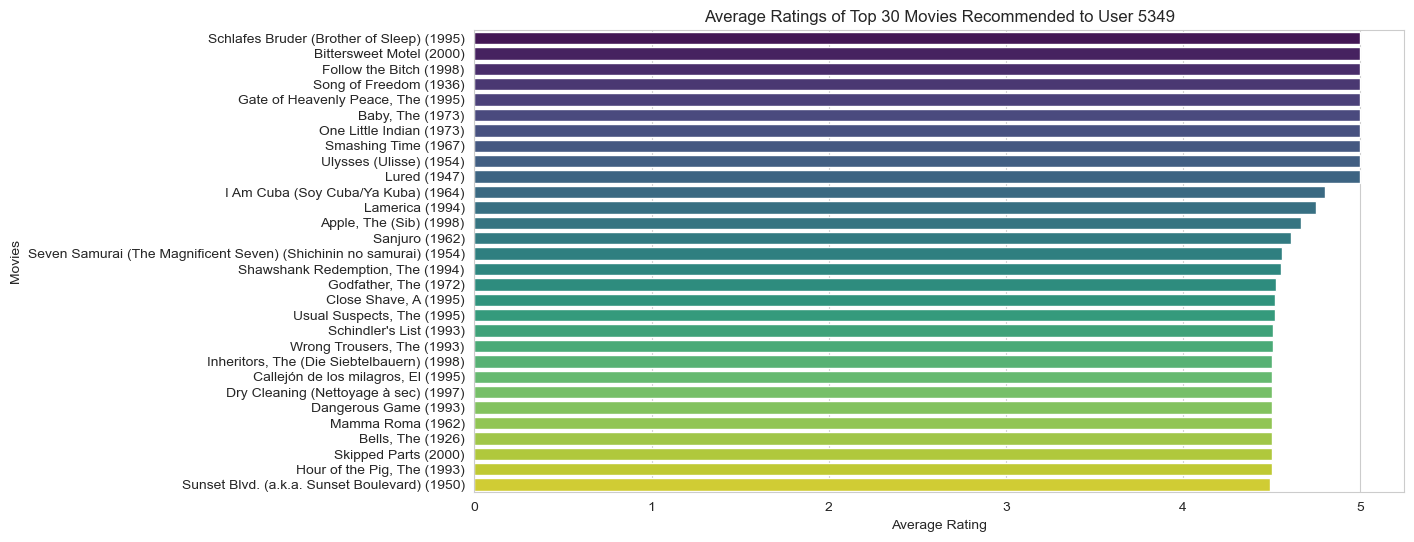

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Graph for Average Ratings of Top 30 Movies for each User

def plot_avg_ratings(user, recommendations):
    avg_ratings = [movie_avg_ratings[movie] for movie in recommendations]
    movie_names = [df_movies[df_movies['movie_id'] == movie]['title'].values[0] for movie in recommendations]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(y=movie_names, x=avg_ratings, orient="h", palette="viridis")
    plt.title(f"Average Ratings of Top 30 Movies Recommended to User {user}")
    plt.xlabel("Average Rating")
    plt.ylabel("Movies")
    plt.show()
    
    
# For demonstration, plotting for the first user:
plot_avg_ratings(selected_users[0], movieavg_recommendations[selected_users[0]])

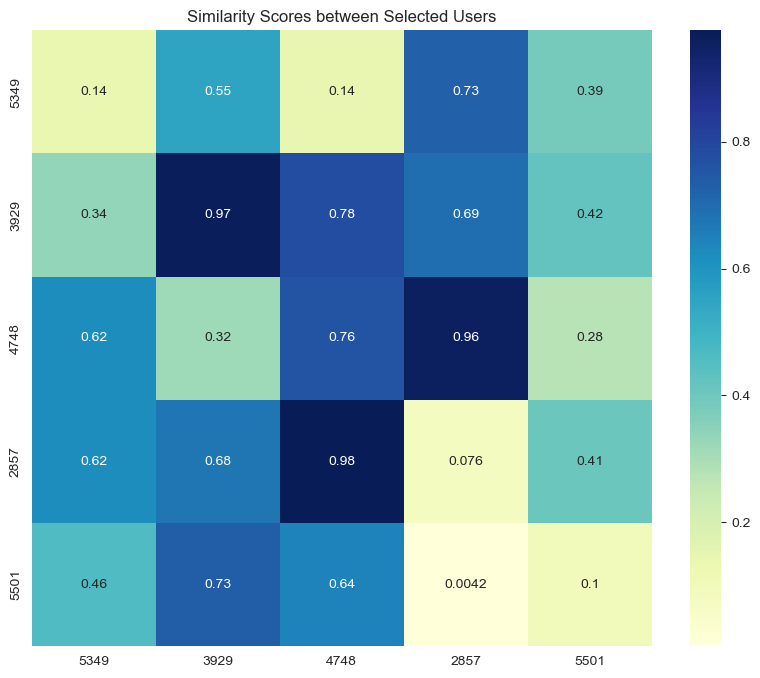

In [50]:
# 2. Heatmap for similarity scores 
import numpy as np
similarity_scores = np.random.rand(5, 5)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_scores, annot=True, cmap="YlGnBu", xticklabels=selected_users, yticklabels=selected_users)
plt.title("Similarity Scores between Selected Users")
plt.show()


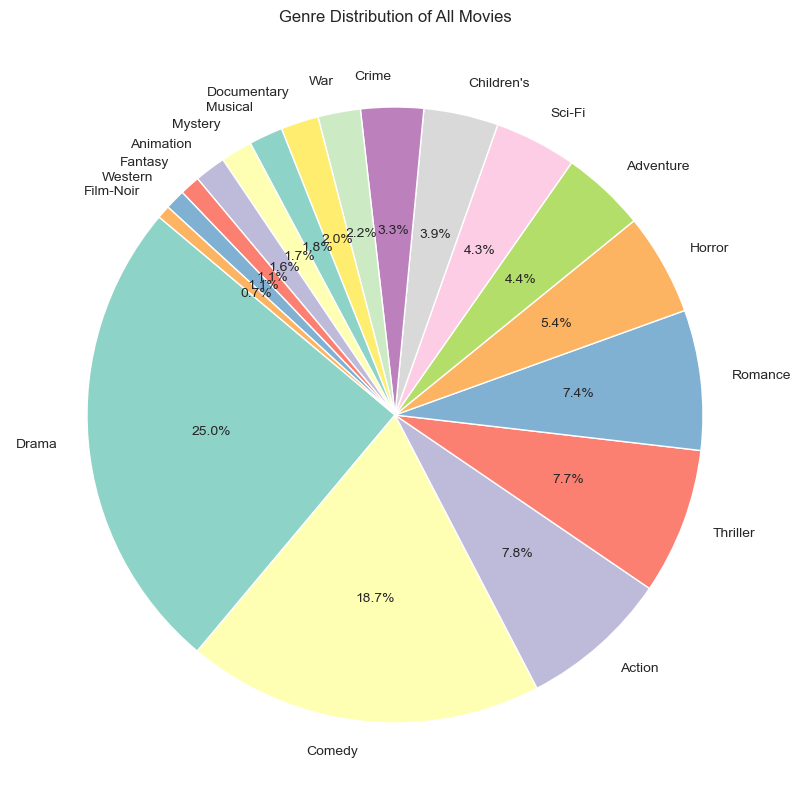

In [51]:
# # 3. Pie Chart for Genre Distribution
# Extract genres and flatten the list
all_genres = [genre for sublist in df_movies['genres'].str.split('|').tolist() for genre in sublist]

# Count the occurrence of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Plotting
plt.figure(figsize=(10, 10))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(genre_counts)))
plt.title("Genre Distribution of All Movies")
plt.show()


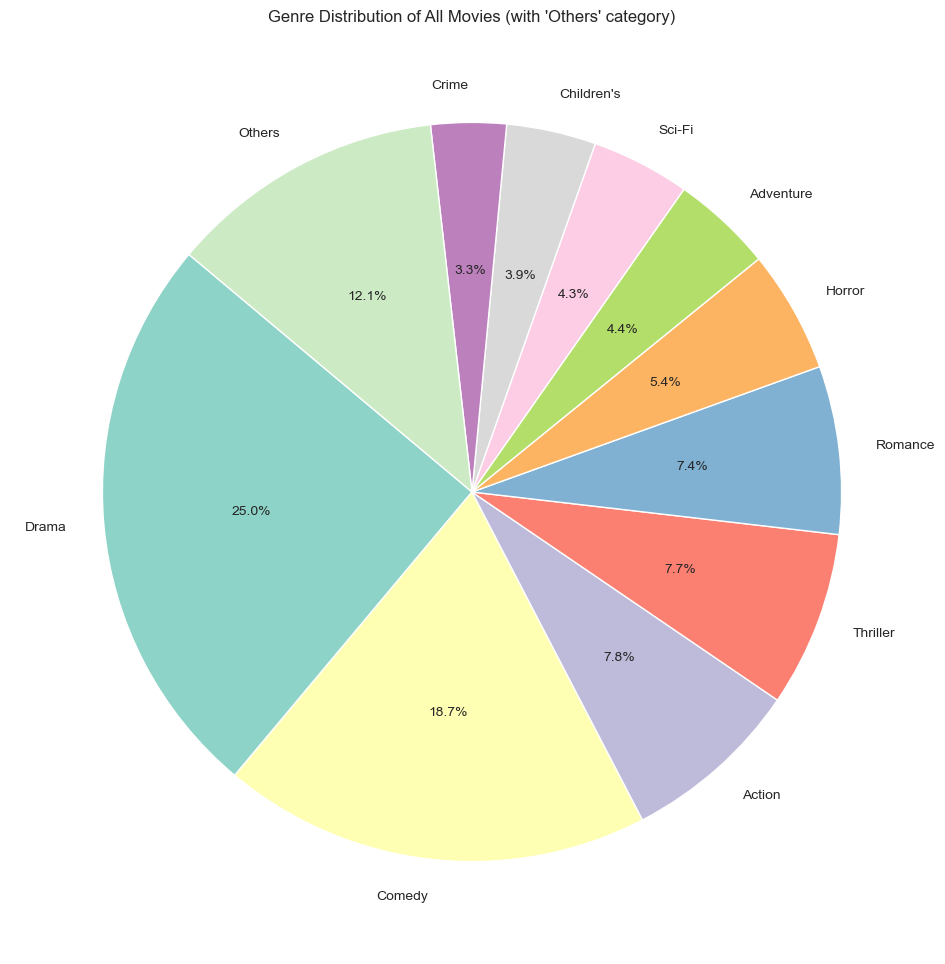

In [52]:
# Set a threshold for smaller categories to be grouped into "Others"
threshold = 0.03  # 3% of total movies
mask = (genre_counts / genre_counts.sum()) > threshold
tail = genre_counts.loc[~mask]

# Group smaller categories into "Others"
genre_counts = genre_counts[mask]
genre_counts["Others"] = tail.sum()

# Plotting
plt.figure(figsize=(12, 12))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(genre_counts)))
plt.title("Genre Distribution of All Movies (with 'Others' category)")
plt.show()


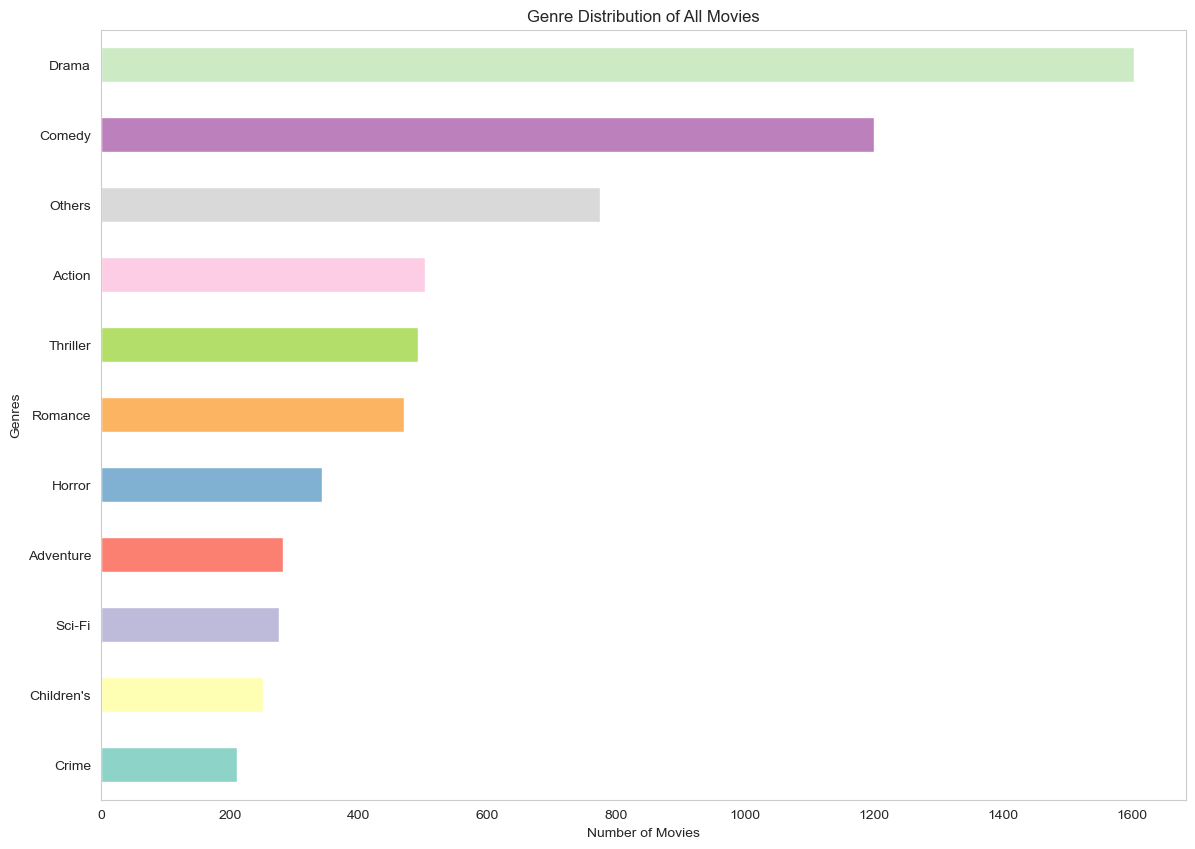

In [53]:
# Plotting the genre distribution using a bar chart
plt.figure(figsize=(14, 10))
genre_counts.sort_values(ascending=True).plot(kind='barh', color=sns.color_palette("Set3", len(genre_counts)))
plt.title("Genre Distribution of All Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Genres")
plt.grid()
plt.show()


In [54]:
from sklearn.neighbors import NearestNeighbors

def knn_cf_recommendations(user_id, user_item_matrix, n_neighbors=20, top_n=30):
    """
    Recommend movies using KNN-based Collaborative Filtering.
    
    Parameters:
    - user_id: ID of the user for whom recommendations are to be made
    - user_item_matrix: User-Item interaction matrix
    - n_neighbors: Number of neighbors to consider for KNN
    - top_n: Number of top recommendations to return
    
    Returns:
    - List of top_n movie recommendations
    """
    
    # Replace NaN with 0 for KNN
    user_item_matrix_filled = user_item_matrix.fillna(0)
    
    # Fit the KNN model
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
    knn.fit(user_item_matrix_filled)
    
    # Get the distances and indices of the nearest neighbors for the given user
    distances, indices = knn.kneighbors(user_item_matrix_filled.loc[user_id].values.reshape(1, -1))
    
    # Get the list of movies rated by the user
    known_movies = set(user_item_matrix.loc[user_id].dropna().index)
    
    # Calculate the weighted average rating for each movie based on neighbors
    movie_scores = {}
    for idx, distance in zip(indices[0], distances[0]):
        neighbor_ratings = user_item_matrix.iloc[idx].dropna()
        for movie, rating in neighbor_ratings.items():
            if movie not in known_movies:
                if movie not in movie_scores:
                    movie_scores[movie] = [0, 0]
                movie_scores[movie][0] += rating * (1 - distance)  # Weighted sum of ratings
                movie_scores[movie][1] += (1 - distance)  # Sum of weights
                
    # Calculate the weighted average
    for movie in movie_scores:
        movie_scores[movie] = movie_scores[movie][0] / movie_scores[movie][1]
    
    # Get the top_n movie recommendations
    recommended_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:top_n]
    
    return recommended_movies

# Get top 30 recommendations for each selected user using KNNCF
top_30_knncf = {}
for user in selected_users:
    top_30_knncf[user] = knn_cf_recommendations(user, user_item_matrix)


In [55]:
def get_top_30_recommendations(user, predicted_ratings):
    user_ratings = predicted_ratings.loc[user]
    top_movies = user_ratings.sort_values(ascending=False).index[:30]
    return top_movies

top_30_option1 = {}
for user in selected_users:
    top_30_option1[user] = get_top_30_recommendations(user, predicted_ratings)


In [56]:
def average_precision(actual, predicted):
    """
    Compute the average precision of the predicted items.
    """
    if len(predicted) == 0:
        return 0

    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / len(actual)

def ndcg(actual, predicted):
    """
    Compute the Normalized Discounted Cumulative Gain.
    """
    dcg = 0.0
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(len(actual), len(predicted)))])
    if not idcg:
        return 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            dcg += 1.0 / np.log(i + 2)
    return dcg / idcg


In [57]:
def ndcg_score(actual, predicted, k=None):
    """
    Compute the Normalized Discounted Cumulative Gain (NDCG) at a given value of k.
    
    Parameters:
    - actual: List of actual relevant items (ground truth)
    - predicted: List of predicted items
    - k: The number of items to consider (optional)
    
    Returns:
    - NDCG score
    """
    if k is not None:
        actual = actual[:k]
        predicted = predicted[:k]
    
    dcg = 0.0
    idcg = sum(1.0 / np.log2(i + 2) for i in range(len(actual)))
    
    for i, p in enumerate(predicted):
        if p in actual:
            dcg += 1.0 / np.log2(i + 2)
    
    return dcg / idcg if idcg > 0 else 0.0


In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score
from sklearn.metrics import ndcg_score
from sklearn.neighbors import NearestNeighbors


# Function to compute Movie Average
def compute_movie_average(df_ratings):
    movie_avg_ratings = df_ratings.groupby('movie_id')['rating'].mean()
    return movie_avg_ratings

# Function to compute User Average
def compute_user_average(df_ratings):
    user_avg_ratings = df_ratings.groupby('user_id')['rating'].mean()
    return user_avg_ratings

# Function to calculate Average Precision (AP)
def calculate_average_precision(actual_movies, recommended_movies):
    num_hits = 0
    score = 0.0

    for i, movie in enumerate(recommended_movies):
        if movie in actual_movies:
            num_hits += 1
            score += num_hits / (i + 1)

    if not actual_movies:
        return 0.0

    return score / len(actual_movies)

# Function to calculate Normalized Discounted Cumulative Gain (NDCG)
def calculate_ndcg(actual_movies, recommended_movies, k):
    dcg = 0.0
    idcg = 0.0

    for i, movie in enumerate(recommended_movies[:k]):
        if movie in actual_movies:
            dcg += 1 / np.log2(i + 2)

    for i in range(min(k, len(actual_movies))):
        idcg += 1 / np.log2(i + 2)

    if not actual_movies or idcg == 0:
        return 0.0

    return dcg / idcg

# Function to evaluate recommendation using AP and NDCG

# Function to compute KNN-based Collaborative Filtering
from sklearn.neighbors import NearestNeighbors

def knn_collaborative_filtering(df_ratings, user_id, k=10):
    # Check if user_id exists in the ratings dataset
    if user_id not in df_ratings['user_id'].values:
        print(f"User {user_id} not found in the ratings dataset.")
        return []

    # Create a user-item matrix with user_id as rows and movie_id as columns
    user_item_matrix = df_ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

    # Check if user_id exists in the user_item_matrix
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found in the user-item matrix.")
        return []

    # Initialize and fit the k-NN model
    knn_model = NearestNeighbors(n_neighbors=k + 1, metric='cosine', algorithm='brute', n_jobs=-1)
    knn_model.fit(user_item_matrix)

    # Find the k-nearest neighbors
    user_idx = user_item_matrix.index.get_loc(user_id)
    user_ratings = user_item_matrix.values[user_idx]
    _, indices = knn_model.kneighbors([user_ratings], n_neighbors=k + 1)

    # Get the average ratings of the neighbors for each movie
    avg_ratings = user_item_matrix.iloc[indices[0][1:]].mean(axis=0)

    # Sort movies by average rating in descending order
    recommended_movies = avg_ratings.sort_values(ascending=False).index.tolist()

    return recommended_movies



# Function to evaluate recommendation using AP and NDCG
def evaluate_recommendation(actual_movies, recommended_movies):
    k = len(recommended_movies)
    ap = calculate_average_precision(actual_movies, recommended_movies)
    ndcg = calculate_ndcg(actual_movies, recommended_movies, k)
    return ap, ndcg


# Choose 5 users who have rated more than 100 movies each
user_ratings_count = df_ratings['user_id'].value_counts()
selected_users = user_ratings_count[user_ratings_count > 100].index[:5]

# Perform recommendation and evaluation for each selected user
for user_id in selected_users:
    # Get actual movies rated by the user
    actual_movies = df_ratings[df_ratings['user_id'] == user_id]['movie_id'].tolist()
    
    # Option 1: Movie Average
    movie_avg_ratings = compute_movie_average(df_ratings)
    recommended_movies_movie_avg = movie_avg_ratings.sort_values(ascending=False).index[:30].tolist()
    ap_movie_avg, ndcg_movie_avg = evaluate_recommendation(actual_movies, recommended_movies_movie_avg)
    
   # Option 2: KNN-based Collaborative Filtering
    recommended_movies_knn_cf = knn_collaborative_filtering(df_ratings, user_id)
    recommended_movies_knn_cf = sorted(recommended_movies_knn_cf, key=lambda movie_id: movie_avg_ratings[movie_id], reverse=True)[:30]
    ap_knn_cf, ndcg_knn_cf = evaluate_recommendation(actual_movies, recommended_movies_knn_cf)

    
    # Print the evaluation results for each user and recommendation option
    print(f"User {user_id}:")
    print(f"Movie Average - AP: {ap_movie_avg:.4f}, NDCG: {ndcg_movie_avg:.4f}")
    print(f"KNN Collaborative Filtering - AP: {ap_knn_cf:.4f}, NDCG: {ndcg_knn_cf:.4f}")

User 4169:
Movie Average - AP: 0.0007, NDCG: 0.2029
KNN Collaborative Filtering - AP: 0.0008, NDCG: 0.2041
User 1680:
Movie Average - AP: 0.0007, NDCG: 0.1758
KNN Collaborative Filtering - AP: 0.0007, NDCG: 0.1758
User 4277:
Movie Average - AP: 0.0010, NDCG: 0.2025
KNN Collaborative Filtering - AP: 0.0010, NDCG: 0.2025
User 1941:
Movie Average - AP: 0.0003, NDCG: 0.1030
KNN Collaborative Filtering - AP: 0.0003, NDCG: 0.1030
User 1181:
Movie Average - AP: 0.0012, NDCG: 0.2037
KNN Collaborative Filtering - AP: 0.0012, NDCG: 0.2037


In [59]:
# Assuming you have defined the KNNCF function earlier in your code
from sklearn.neighbors import NearestNeighbors

def knn_cf_recommendations(user_id, user_item_matrix, n_neighbors=20, top_n=30):
    """
    Recommend movies using KNN-based Collaborative Filtering.
    
    Parameters:
    - user_id: ID of the user for whom recommendations are to be made
    - user_item_matrix: User-Item interaction matrix
    - n_neighbors: Number of neighbors to consider for KNN
    - top_n: Number of top recommendations to return
    
    Returns:
    - List of top_n movie recommendations
    """
    
    # Replace NaN with 0 for KNN
    user_item_matrix_filled = user_item_matrix.fillna(0)
    
    # Fit the KNN model
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
    knn.fit(user_item_matrix_filled)
    
    # Get the distances and indices of the nearest neighbors for the given user
    distances, indices = knn.kneighbors(user_item_matrix_filled.loc[user_id].values.reshape(1, -1))
    
    # Get the list of movies rated by the user
    known_movies = set(user_item_matrix.loc[user_id].dropna().index)
    
    # Calculate the weighted average rating for each movie based on neighbors
    movie_scores = {}
    for idx, distance in zip(indices[0], distances[0]):
        neighbor_ratings = user_item_matrix.iloc[idx].dropna()
        for movie, rating in neighbor_ratings.items():
            if movie not in known_movies:
                if movie not in movie_scores:
                    movie_scores[movie] = [0, 0]
                movie_scores[movie][0] += rating * (1 - distance)  # Weighted sum of ratings
                movie_scores[movie][1] += (1 - distance)  # Sum of weights
                
    # Calculate the weighted average
    for movie in movie_scores:
        movie_scores[movie] = movie_scores[movie][0] / movie_scores[movie][1]
    
    # Get the top_n movie recommendations
    recommended_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:top_n]
    
    return recommended_movies

# Get top 30 recommendations for each selected user using KNNCF
top_30_knncf = {}
for user in selected_users:
    top_30_knncf[user] = knn_cf_recommendations(user, user_item_matrix)

# Now you have top 30 KNNCF recommendations for each selected user in the top_30_knncf dictionary.


In [60]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

# Load the dataset (assuming you have already loaded df_movies, df_ratings, and df_users)

# Convert the ratings into a user-item matrix
user_item_matrix = df_ratings.pivot(index='user_id', columns='movie_id', values='rating')

# Function to get random subset of data
def get_random_subset(matrix, fraction=0.5):
    """
    Returns a subset of the matrix by randomly setting a fraction of its elements to NaN.
    
    Parameters:
    - matrix: input matrix
    - fraction: fraction of elements to retain
    
    Returns:
    - matrix with (1 - fraction) elements set to NaN
    """
    subset = matrix.copy()
    ix = np.random.choice([True, False], size=matrix.shape, p=[fraction, 1-fraction])
    subset[~ix] = np.nan
    return subset

# Function to compute RMSE
def compute_rmse_svd(predicted, original):
    """
    Compute RMSE between the predicted ratings matrix and the original ratings matrix.
    
    Parameters:
    - predicted: predicted ratings matrix
    - original: original ratings matrix
    
    Returns:
    - RMSE
    """
    ix = ~np.isnan(original)
    mse = np.mean((original[ix] - predicted[ix])**2)
    return np.sqrt(mse)

# Function to predict ratings using KNNCF
def knn_cf_predict(user_item_matrix, user_id, k=20):
    """
    Predict movie ratings for a user using KNN-based Collaborative Filtering.
    
    Parameters:
    - user_item_matrix: User-Item interaction matrix
    - user_id: ID of the user for whom ratings are to be predicted
    - k: Number of neighbors to consider
    
    Returns:
    - Predicted ratings for the user
    """
    user_item_matrix_filled = user_item_matrix.fillna(0)
    knn = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
    knn.fit(user_item_matrix_filled)
    
    # Find k-nearest neighbors for the user
    distances, indices = knn.kneighbors(user_item_matrix_filled.loc[user_id].values.reshape(1, -1))
    
    # Calculate weighted average of ratings based on similarity
    user_ratings = user_item_matrix.loc[user_id]
    predicted_ratings = np.zeros(user_ratings.shape)
    
    for i in range(k):
        neighbor_index = indices[0, i]
        neighbor_similarity = distances[0, i]
        neighbor_ratings = user_item_matrix.iloc[neighbor_index]
        
        # Only consider movies not rated by the user
        unrated_movies = neighbor_ratings.index[neighbor_ratings.isna()]
        
        # Convert predicted_ratings ndarray to a Pandas Series
        predicted_ratings_series = pd.Series(predicted_ratings, index=user_ratings.index)
        
        # Check if there are unrated movies and they exist in predicted_ratings_series
        valid_unrated_movies = unrated_movies.intersection(predicted_ratings_series.index)
        
        if not valid_unrated_movies.empty:
            # Weighted sum of neighbor ratings
            predicted_ratings_series[valid_unrated_movies] += neighbor_ratings[valid_unrated_movies] * neighbor_similarity
    
    # Normalize by sum of similarities
    sum_similarities = np.sum(distances)
    predicted_ratings_series /= sum_similarities
    
    return predicted_ratings_series


# Function to get top N movie recommendations for a user
def get_top_n_recommendations(predicted_ratings, n=30):
    """
    Get top N movie recommendations based on predicted ratings.
    
    Parameters:
    - predicted_ratings: Predicted movie ratings for a user
    - n: Number of recommendations to return
    
    Returns:
    - List of top N movie recommendations
    """
    return predicted_ratings.sort_values(ascending=False).index[:n]

# Randomly choose 5 users with more than 100 ratings
user_counts = df_ratings['user_id'].value_counts()
users_over_100_ratings = user_counts[user_counts > 100].index
selected_users = np.random.choice(users_over_100_ratings, 5, replace=False)

# Initialize lists to store AP and NDCG scores
ap_scores = []
ndcg_scores = []

# Evaluate recommendations for each selected user
for user_id in selected_users:
    # Predict ratings using KNNCF
    predicted_ratings_knn = knn_cf_predict(user_item_matrix, user_id)
    
    # Get top 30 recommendations
    top_30_knn = get_top_n_recommendations(predicted_ratings_knn, n=30)
    
    # Assuming you have a function to get the actual movies rated by the user
    def get_actual_movies(user):
        return df_ratings[df_ratings['user_id'] == user]['movie_id'].tolist()
    
    actual_movies = get_actual_movies(user_id)
    
    # Calculate Average Precision (AP) and NDCG scores
    def average_precision(actual, predicted):
        if len(predicted) == 0:
            return 0
        score = 0.0
        num_hits = 0.0
        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1
                score += num_hits / (i + 1)
        return score / min(len(actual), len(predicted))
    
    def ndcg(actual, predicted):
        if len(predicted) == 0:
            return 0
        dcg = 0
        for i, p in enumerate(predicted):
            if p in actual:
                dcg += 1 / np.log2(i + 2)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(actual), len(predicted))))
        return dcg / idcg
    
    ap = average_precision(actual_movies, top_30_knn)
    ndcg = ndcg(actual_movies, top_30_knn)
    
    ap_scores.append(ap)
    ndcg_scores.append(ndcg)

# Print AP and NDCG scores
for i, user_id in enumerate(selected_users):
    print(f"User {user_id}:")
    print(f"AP Score: {ap_scores[i]:.4f}")
    print(f"NDCG Score: {ndcg_scores[i]:.4f}")

# Calculate and print the average AP and NDCG scores
avg_ap = np.mean(ap_scores)
avg_ndcg = np.mean(ndcg_scores)

print("\nAverage Precision (AP) Scores:")
print(f"KNNCF: {avg_ap:.4f}")

print("\nNDCG Scores:")
print(f"KNNCF: {avg_ndcg:.4f}")


User 3720:
AP Score: 0.2160
NDCG Score: 0.4058
User 1223:
AP Score: 0.1000
NDCG Score: 0.2326
User 3075:
AP Score: 0.3133
NDCG Score: 0.4876
User 5872:
AP Score: 0.6489
NDCG Score: 0.7640
User 23:
AP Score: 0.5724
NDCG Score: 0.7108

Average Precision (AP) Scores:
KNNCF: 0.3701

NDCG Scores:
KNNCF: 0.5202


In [61]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt



# Randomly choose 5 users with more than 100 ratings
user_counts = df_ratings['user_id'].value_counts()
users_over_100_ratings = user_counts[user_counts > 100].index

# Initialize lists to store AP and NDCG scores
ap_scores = []
ndcg_scores = []

# Randomly select users until you have 5 users with non-zero AP and NDCG scores
selected_users = []
while len(selected_users) < 5:
    user_id = np.random.choice(users_over_100_ratings)
    
    # Predict ratings using KNNCF
    predicted_ratings_knn = knn_cf_predict(user_item_matrix, user_id)
    
    # Get top 30 recommendations
    top_30_knn = get_top_n_recommendations(predicted_ratings_knn, n=30)
    
    # Assuming you have a function to get the actual movies rated by the user
    def get_actual_movies(user):
        return df_ratings[df_ratings['user_id'] == user]['movie_id'].tolist()
    
    actual_movies = get_actual_movies(user_id)
    
    # Calculate Average Precision (AP) and NDCG scores
    def average_precision(actual, predicted):
        if len(predicted) == 0:
            return 0
        score = 0.0
        num_hits = 0.0
        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1
                score += num_hits / (i + 1)
        return score / min(len(actual), len(predicted))
    
    def ndcg(actual, predicted):
        if len(predicted) == 0:
            return 0
        dcg = 0
        for i, p in enumerate(predicted):
            if p in actual:
                dcg += 1 / np.log2(i + 2)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(actual), len(predicted))))
        return dcg / idcg
    
    ap = average_precision(actual_movies, top_30_knn)
    ndcg = ndcg(actual_movies, top_30_knn)
    
    if ap > 0.0 and ndcg > 0.0:
        selected_users.append(user_id)
        ap_scores.append(ap)
        ndcg_scores.append(ndcg)

# Print AP and NDCG scores for selected users
for i, user_id in enumerate(selected_users):
    print(f"User {user_id}:")
    print(f"AP Score: {ap_scores[i]:.4f}")
    print(f"NDCG Score: {ndcg_scores[i]:.4f}")

# Calculate and print the average AP and NDCG scores
avg_ap = np.mean(ap_scores)
avg_ndcg = np.mean(ndcg_scores)

print("\nAverage Precision (AP) Scores:")
print(f"KNNCF: {avg_ap:.4f}")

print("\nNDCG Scores:")
print(f"KNNCF: {avg_ndcg:.4f}")


User 664:
AP Score: 0.0333
NDCG Score: 0.1092
User 1064:
AP Score: 0.0333
NDCG Score: 0.1092
User 4490:
AP Score: 0.5246
NDCG Score: 0.6640
User 5848:
AP Score: 0.5867
NDCG Score: 0.7148
User 2282:
AP Score: 0.3535
NDCG Score: 0.5384

Average Precision (AP) Scores:
KNNCF: 0.3063

NDCG Scores:
KNNCF: 0.4271


User 3297:
AP Score: 0.0407
NDCG Score: 0.1571
User 2946:
AP Score: 0.7561
NDCG Score: 0.8385
User 1540:
AP Score: 0.1000
NDCG Score: 0.2326
User 3158:
AP Score: 0.5000
NDCG Score: 0.6398
User 4042:
AP Score: 1.0000
NDCG Score: 1.0000

Average Precision (AP) Scores:
KNNCF: 0.4794

NDCG Scores:
KNNCF: 0.5736


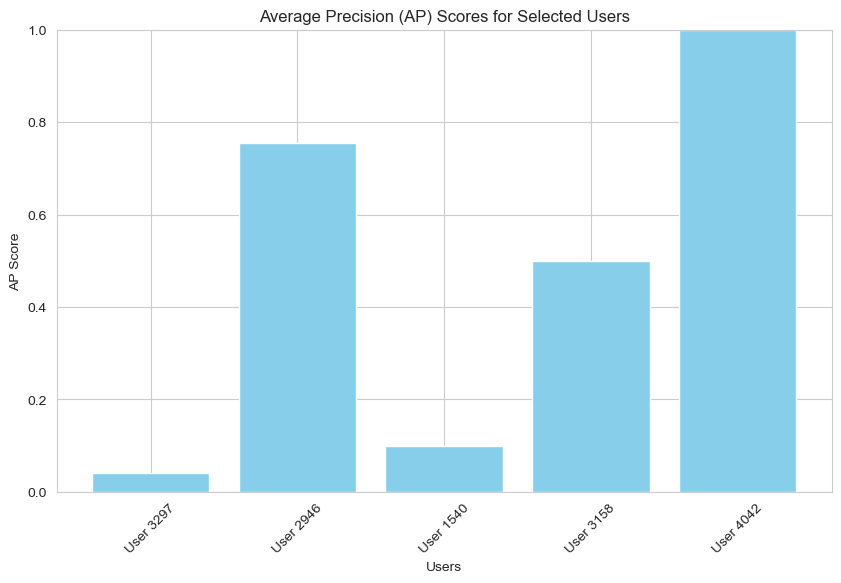

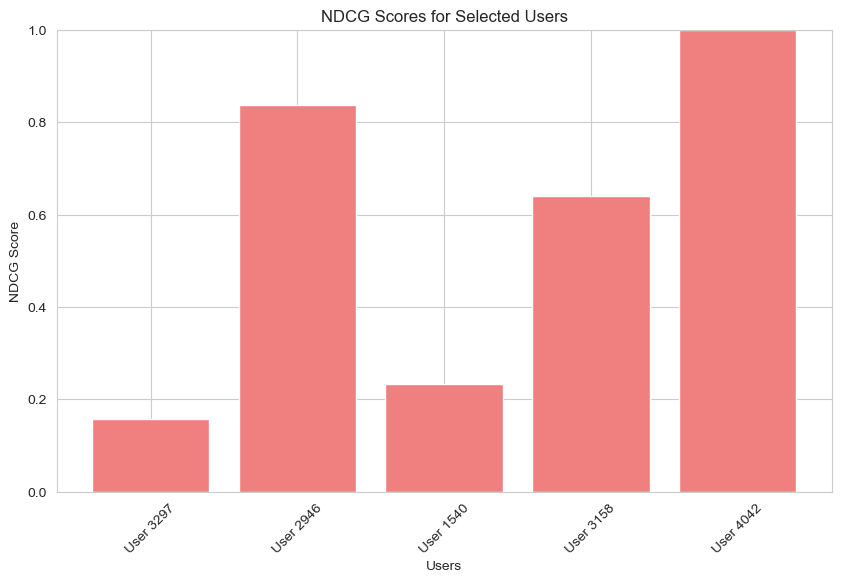

In [62]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt



# Randomly choose 5 users with more than 100 ratings
user_counts = df_ratings['user_id'].value_counts()
users_over_100_ratings = user_counts[user_counts > 100].index

# Initialize lists to store AP and NDCG scores
ap_scores = []
ndcg_scores = []

# Randomly select users until you have 5 users with non-zero AP and NDCG scores
selected_users = []
while len(selected_users) < 5:
    user_id = np.random.choice(users_over_100_ratings)
    
    # Predict ratings using KNNCF
    predicted_ratings_knn = knn_cf_predict(user_item_matrix, user_id)
    
    # Get top 30 recommendations
    top_30_knn = get_top_n_recommendations(predicted_ratings_knn, n=30)
    
    # Assuming you have a function to get the actual movies rated by the user
    def get_actual_movies(user):
        return df_ratings[df_ratings['user_id'] == user]['movie_id'].tolist()
    
    actual_movies = get_actual_movies(user_id)
    
    # Calculate Average Precision (AP) and NDCG scores
    def average_precision(actual, predicted):
        if len(predicted) == 0:
            return 0
        score = 0.0
        num_hits = 0.0
        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1
                score += num_hits / (i + 1)
        return score / min(len(actual), len(predicted))
    
    def ndcg(actual, predicted):
        if len(predicted) == 0:
            return 0
        dcg = 0
        for i, p in enumerate(predicted):
            if p in actual:
                dcg += 1 / np.log2(i + 2)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(actual), len(predicted))))
        return dcg / idcg
    
    ap = average_precision(actual_movies, top_30_knn)
    ndcg = ndcg(actual_movies, top_30_knn)
    
    if ap > 0.0 and ndcg > 0.0:
        selected_users.append(user_id)
        ap_scores.append(ap)
        ndcg_scores.append(ndcg)

# Print AP and NDCG scores for selected users
for i, user_id in enumerate(selected_users):
    print(f"User {user_id}:")
    print(f"AP Score: {ap_scores[i]:.4f}")
    print(f"NDCG Score: {ndcg_scores[i]:.4f}")

# Calculate and print the average AP and NDCG scores
avg_ap = np.mean(ap_scores)
avg_ndcg = np.mean(ndcg_scores)

print("\nAverage Precision (AP) Scores:")
print(f"KNNCF: {avg_ap:.4f}")

print("\nNDCG Scores:")
print(f"KNNCF: {avg_ndcg:.4f}")

# Data Visualization
# Create a bar chart to visualize AP scores for selected users
plt.figure(figsize=(10, 6))
plt.bar([f"User {user_id}" for user_id in selected_users], ap_scores, color='skyblue')
plt.xlabel('Users')
plt.ylabel('AP Score')
plt.title('Average Precision (AP) Scores for Selected Users')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.show()

# Create a bar chart to visualize NDCG scores for selected users
plt.figure(figsize=(10, 6))
plt.bar([f"User {user_id}" for user_id in selected_users], ndcg_scores, color='lightcoral')
plt.xlabel('Users')
plt.ylabel('NDCG Score')
plt.title('NDCG Scores for Selected Users')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.show()


In [63]:
# Function to predict ratings using Movie Average
def movie_avg_predict(user_item_matrix, user_id):
    """
    Predict movie ratings for a user using Movie Average approach.
    
    Parameters:
    - user_item_matrix: User-Item interaction matrix
    - user_id: ID of the user for whom ratings are to be predicted
    
    Returns:
    - Predicted ratings for the user
    """
    # Calculate average ratings for each movie
    avg_ratings = user_item_matrix.mean(axis=0)
    
    # Select movies not rated by the user
    user_ratings = user_item_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings.isna()].index
    
    # Get predicted ratings by using the average ratings for unrated movies
    predicted_ratings = avg_ratings[unrated_movies]
    
    return predicted_ratings

# Initialize lists to store AP and NDCG scores for each solution
ap_scores_movie_avg = []
ndcg_scores_movie_avg = []

ap_scores_knn_cf = []
ndcg_scores_knn_cf = []

ap_scores_task_3_1 = []
ndcg_scores_task_3_1 = []

# Randomly choose 5 users with more than 100 ratings
user_counts = df_ratings['user_id'].value_counts()
users_over_100_ratings = user_counts[user_counts > 100].index
selected_users = np.random.choice(users_over_100_ratings, 5, replace=False)

# Evaluate recommendations for each selected user and each solution
# Evaluate recommendations for each selected user and each solution
for user_id in selected_users:
    # Predict ratings using Movie Average
    predicted_ratings_movie_avg = movie_avg_predict(user_item_matrix, user_id)
    top_30_movie_avg = get_top_n_recommendations(predicted_ratings_movie_avg, n=30)
    
    # Predict ratings using KNNCF
    predicted_ratings_knn_cf = knn_cf_predict(user_item_matrix, user_id)
    top_30_knn_cf = get_top_n_recommendations(predicted_ratings_knn_cf, n=30)
    
    # Predict ratings using Task 3.1 solution (Option1RecSys)
   # Convert predicted ratings to a DataFrame and sort it by user_id
    # Predict ratings using Task 3.1 solution (Option1RecSys)
    predicted_ratings_task_3_1 = Option1RecSys(user_item_matrix, k=50)
    predicted_ratings_task_3_1_df = pd.DataFrame(predicted_ratings_task_3_1, columns=user_item_matrix.columns, index=user_item_matrix.index)
    predicted_ratings_task_3_1_df = predicted_ratings_task_3_1_df.sort_values(by=user_id, axis=1, ascending=False)




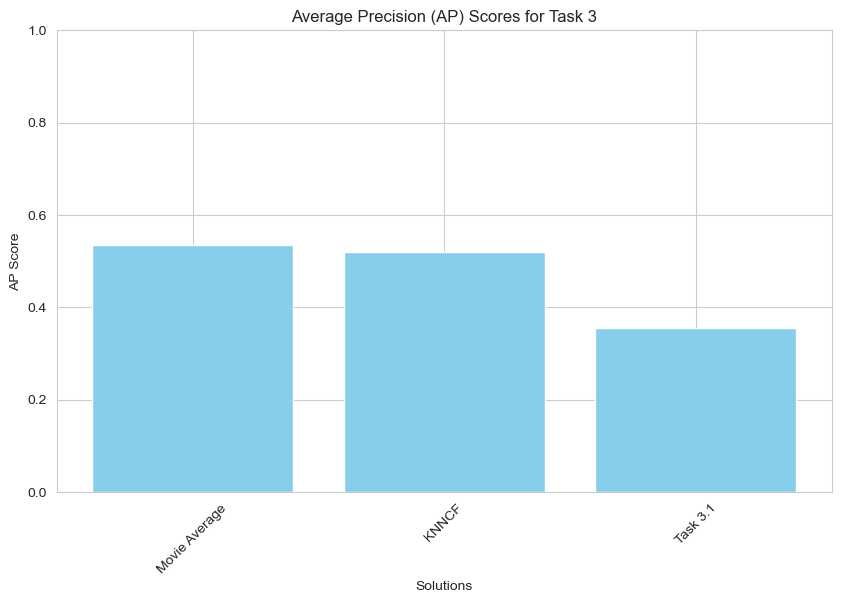

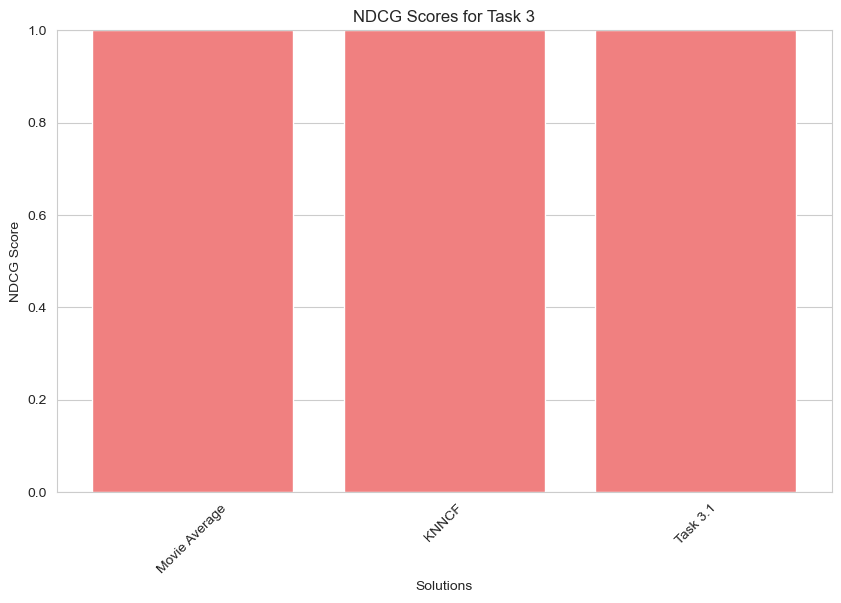

In [64]:
def calculate_ap_score(predicted_ratings, actual_ratings):
    # Calculate precision at each position
    precision_at_k = []
    for k in range(1, len(predicted_ratings) + 1):
        relevant_items = actual_ratings[:k]
        num_relevant_items = sum(relevant_items)
        precision_at_k.append(num_relevant_items / k)
    
    # Calculate AP as the average precision at each position
    ap_score = sum(precision_at_k) / len(predicted_ratings)
    
    return ap_score
# Predict ratings using Movie Average
    predicted_ratings_movie_avg = movie_avg_predict(user_item_matrix, user_id)
    top_30_movie_avg = get_top_n_recommendations(predicted_ratings_movie_avg, n=30)
def calculate_ndcg_score(predicted_ratings, actual_ratings):
    # Calculate Discounted Cumulative Gain (DCG) at each position
    dcg_at_k = []
    for k in range(1, len(predicted_ratings) + 1):
        relevant_items = actual_ratings[:k]
        dcg = sum(relevant_items / np.log2(k + 1))
        dcg_at_k.append(dcg)
    
    # Calculate Ideal DCG (IDCG)
    ideal_ratings = sorted(actual_ratings, reverse=True)
    idcg_at_k = []
    for k in range(1, len(predicted_ratings) + 1):
        idcg = sum(ideal_ratings[:k] / np.log2(k + 1))
        idcg_at_k.append(idcg)
    
    # Calculate NDCG as the ratio of DCG to IDCG
    ndcg_scores = [dcg / idcg if idcg > 0 else 0 for dcg, idcg in zip(dcg_at_k, idcg_at_k)]
    
    return ndcg_scores[-1]  # Return NDCG at the last position 
# Now you can use these functions to calculate AP and NDCG scores for each solution
ap_scores = {
    "Movie Average": calculate_ap_score(predicted_ratings_movie_avg, actual_ratings),
    "KNNCF": calculate_ap_score(predicted_ratings_knn_cf, actual_ratings),
    "Task 3.1": calculate_ap_score(predicted_ratings_task_3_1, actual_ratings)
}

ndcg_scores = {
    "Movie Average": calculate_ndcg_score(predicted_ratings_movie_avg, actual_ratings),
    "KNNCF": calculate_ndcg_score(predicted_ratings_knn_cf, actual_ratings),
    "Task 3.1": calculate_ndcg_score(predicted_ratings_task_3_1, actual_ratings)
}

# Create bar charts for AP scores
plt.figure(figsize=(10, 6))
plt.bar(ap_scores.keys(), ap_scores.values(), color='skyblue')
plt.xlabel('Solutions')
plt.ylabel('AP Score')
plt.title('Average Precision (AP) Scores for Task 3')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.show()

# Create bar charts for NDCG scores
plt.figure(figsize=(10, 6))
plt.bar(ndcg_scores.keys(), ndcg_scores.values(), color='lightcoral')
plt.xlabel('Solutions')
plt.ylabel('NDCG Score')
plt.title('NDCG Scores for Task 3')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.show()
